# 人臉偵測 - OpenCV (Haar特徵分類器)

這個Notebook主要是介詔OpenCV的Haar特徵分類器來進行在一個圖像進行人臉的偵測與定位。雖然現在己經有很多手法可以進行更精準的人臉的偵測與定位,但是OpenCV的Haar仍然有其簡單快速的特性。同時也可以用它來作為一個評鑑其它方法的一個基準。


![face-detection](http://kuznech.com/wp-content/uploads/2013/12/fd_for_odniklassniki.jpg)

### 需求

- [OpenCV](https://opencv.org/)

OpenCV是出了名不容易從源碼編譯安裝的package, 因此建議使用Anaconda來進行OpenCV的安裝:

```
conda install -c conda-forge opencv
```

### 專案的檔案路徑佈局

1. 從[OpenCV的GitHub](https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_alt2.xml)下載Haar模型權重檔以下指定目錄。
    
你的目錄結構看起來像這樣: (這裡只列出來在這個範例會用到的相關檔案與目錄)
```
open-cv-face-detection/
├── xxxx.ipynb
├── model/
│   └── cv2/
│       └── haarcascade_frontalface_alt2.xml
└── data/
    ├── images/              <--- 驗證圖像的位置
    └── videos/              <--- 驗證影像的位置
```

### STEP 1. 載入相關函式庫

In [1]:
# Utilities相關函式庫
import os
import sys
import random
from tqdm import tqdm

# 圖像處理/展現的相關函式庫
import cv2
import matplotlib.pyplot as plt

#### 設定相關設定與參數

In [2]:
# 專案的根目錄路徑
ROOT_DIR = os.getcwd()

# 訓練/驗證用的資料目錄
DATA_PATH = os.path.join(ROOT_DIR, "data")

# 訓練/驗證用的圖像資料目錄
TEST_IMGS_PATH = os.path.join(DATA_PATH, "images")

# 存放預訓練模型/權重的資料目錄
MODEL_PATH = os.path.join(ROOT_DIR, "model")

# OpenCV的Haar模型目錄
CV2_MODEL_PATH = os.path.join(MODEL_PATH, "cv2")

# Haar權重檔
HAAR_WEIGHT_FILE = os.path.join(CV2_MODEL_PATH, "haarcascade_frontalface_alt2.xml")

### STEP 2. 構建Cv2 Haar模型實例

In [3]:
# 透過cv2.CascadeClassifier來產生實例
facesDetector = cv2.CascadeClassifier(HAAR_WEIGHT_FILE)

### STEP 3. 圖像中的人臉偵測

In [4]:
# 用來測試OpenCV自帶的Haar的人臉偵測的圖像
test_image= os.path.join(TEST_IMGS_PATH, "faces.jpg") # <-- 俢改不同的圖像來比較效果

In [5]:
# 使用OpenCV讀入測試圖像

# 注意: OpenCV讀進來的圖像所產生的Numpy Ndaary格式是BGR (B:Blue, G: Green, R: Red) 
#      跟使用PIL或skimage的格式RGB (R: Red, G: Green, B:Blue)在色階(channel)的順序上有所不同
bgr_image = cv2.imread(test_image) 

# 將BGR圖像轉成灰階
gray_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)

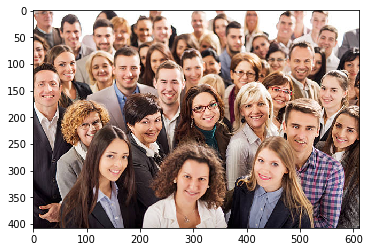

In [6]:
# 秀出原圖像
plt.imshow(bgr_image[:,:,::-1]) # Matplotlib在打印圖像預期是RGB格式, 因此在這裡把BGR轉換成RGB
plt.show()

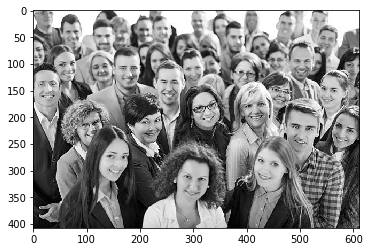

In [7]:
# 秀出灰階圖像
plt.imshow(gray_image, cmap='gray')
plt.show()

opencv2中人臉檢測使用的是`detectMultiScale`函數。它可以檢測出圖片中所有的人臉，並將人臉用矢量保存各個人臉的坐標，大小（用矩形表示）。

`detectMultiScale`函數介紹：

* 參數1：`image`--待檢測圖片，一般為灰度圖像加快檢測速度
* 參數2：`scaleFactor`--表示在前後兩次相繼的掃描中，搜索窗口的比例係數默認為1.1即每次搜索窗口依次擴大10％
* 參數3：`minNeighbors`--表示構成檢測目標的相鄰矩形的最小個數（默認為3個）。
        如果組成檢測目標的小矩形的個數和小於min_neighbors  -  1都會被排除。
        如果min_neighbors為0，則函數不做任何操作就返回所有的被檢候選矩形框，
        這種設定值一般用在用戶自定義對檢測結果的組合程序上
* 參數4：`flags`--要么使用默認值，要么使用CV_HAAR_DO_CANNY_PRUNING，如果設置為CV_HAAR_DO_CANNY_PRUNING，那麼函數將會使用坎尼邊緣檢測來排除邊緣過多或過少的區域，因此這些區域通常不會是人臉所在區域
* 參數6,7：`minSize`屬性和`maxSize`屬性用來限制得到的目標區域的範圍。

### 進行偵測圖像中的人臉

In [8]:
# detectMultiScale方法它可以檢測出圖片中所有的人臉，並將人臉用向量保存各個人臉的坐標，大小（用矩形表示）
faces = facesDetector.detectMultiScale(gray_image,1.3, 5)

# 偵測出來的結果的資料結構 (x, y, w, h) -> 左上角的(x,y)座標, 以及矩型的寬高(w, h)
print("Faces detected: ", len(faces))
print("Result data shape: ",faces.shape)
print("1st data: ", faces[0])

Faces detected:  15
Result data shape:  (15, 4)
1st data:  [265 287  74  74]


### 把結果在原圖像中展現

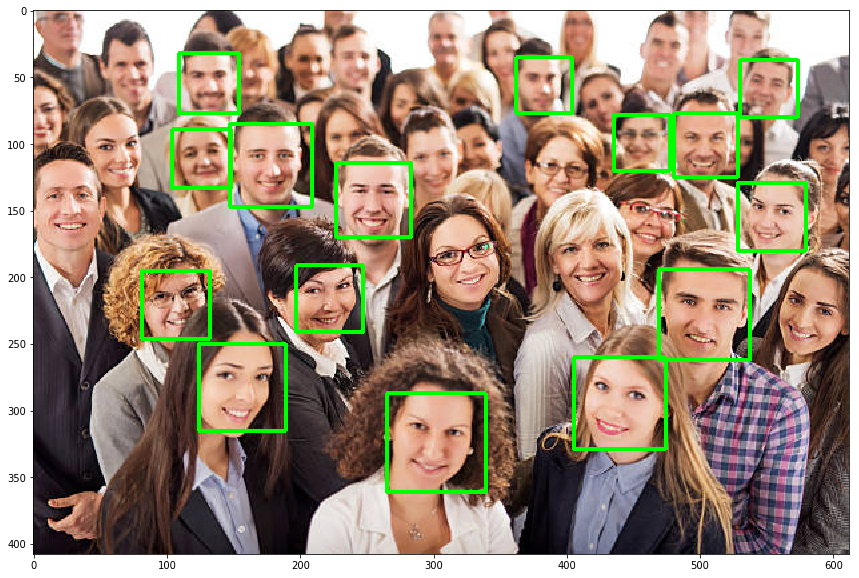

In [9]:
# 迭代每一個偵測的人臉位置 (x, y, w, h) -> 左上角的(x,y)座標, 以及矩型的寬高(w, h)
for (x, y, w, h) in faces:
    # 透過OpenCV來把邊界框畫出來
    # rectangle
    # 參數:
    #     要畫矩形的圖像
    #     左上角座標 tuple (x, y)
    #     右下角座標 tuple (x, y)
    #     邊框顏色 tuple (r,g,b)
    #     邊框寬度 int
    cv2.rectangle(bgr_image, (x,y), (x+w, y+h), (0,255,0), 2)

# 秀出結果
plt.figure(figsize=(20,10))
plt.imshow(bgr_image[:,:,::-1])
plt.show()

### STEP 4. 影像中的人臉偵測

In [11]:
# 資料集目錄
TEST_VIDEOS_PATH = os.path.join(DATA_PATH, "videos")

# 選擇要進行人臉偵測的影像檔
# 在這個測試我從YOUTUBE下載了: https://www.youtube.com/watch?v=aN862xUWt5I
video_inp =  os.path.join(TEST_VIDEOS_PATH, "shoulder.mp4")

# 偵測結果的輸出影像檔
video_out =  os.path.join(TEST_VIDEOS_PATH, "shoulder-haar.mp4")

# 透過OpenCv擷取影像
video_reader = cv2.VideoCapture(video_inp)

# 取得影像的基本資訊
nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT)) # 總共有多少frames
frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))  # 每個frame的高
frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))   # 每個frame的寬

# 找出OpenCV的version
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

# 找出原始影像的fps(frame per seconds)
if int(major_ver)  < 3 :
    fps = video_reader.get(cv2.cv.CV_CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
else :
    fps = video_reader.get(cv2.CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))
        
# 設定影像的輸出
video_writer = cv2.VideoWriter(video_out,
                               cv2.VideoWriter_fourcc(*'XVID'), 
                               fps, # 設定輸出的fps
                               (frame_w, frame_h))
# 計算有多少人臉被識別出來
total_faces_detected = 0

# 迭代每一個frame來進行圖像偵測
for i in tqdm(range(nb_frames)):
    ret, bgr_image = video_reader.read() # 讀取一個frame
    
    # 將BGR圖像轉成灰階
    gray_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)
    
    # 人臉偵測
    faces = facesDetector.detectMultiScale(gray_image,1.3, 5)
    
    # 把這個frame所識別出來的人臉計數記錄下來
    total_faces_detected += len(faces) 
    
    # 迭代每一個偵測的人臉位置 (x, y, w, h) -> 左上角的(x,y)座標, 以及矩型的寬高(w, h)
    for (x, y, w, h) in faces:
        # 透過OpenCV來把邊界框畫出來       
        cv2.rectangle(bgr_image, (x,y), (x+w, y+h), (0,255,0), 2)
        
    # 透過OpenCV把影像輸出出來
    video_writer.write(bgr_image)
    
video_reader.release() # 釋放資源
video_writer.release() # 釋放資源

Frames per second using video.get(cv2.CAP_PROP_FPS) : 29.97002997002997


100%|██████████████████████████████████████████████████████████████████████████████| 5264/5264 [27:50<00:00,  3.15it/s]


In [12]:
print("Total faces detected: ", total_faces_detected)

Total faces detected:  15555
